#### 환경 설정

1. 필요한 라이브러리 다운

In [1]:
! pip install ultralytics
! pip incstall opencv-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 49.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 117.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 96.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 46.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 97.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling

In [2]:
### 모델 관련 ----
import ultralytics
from ultralytics import YOLO
# 제대로 설치되었는지 확인하는 코드
ultralytics.checks()
### 경로 설정 시 ----
import os
### 바운딩박스 생성 시 ----
from PIL import Image
### 데이터 증강 ----
import albumentations as A
from albumentations.pytorch import ToTensorV2
### 데이터 분리할 때 사용 ----
import random
import shutil
### yaml 파일 생성 ----
import yaml
#### 그림 그리고, 레이블링 할 때 ----
import cv2
import matplotlib.pyplot as plt
### 혹시 모르니까 설치하는 부분 ----
import pandas as pd
import numpy as np

Ultralytics 8.3.146 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 38.8/112.6 GB disk)


/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.8' (you have '2.0.5'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


2. 경로 설정

In [3]:
### 데이터 ---- *나중에 없으면 만들도록 할 수 있음! 일단 정해만 두기
# 현재 데이터 있는 곳
base_path = "/content/drive/MyDrive/5. MY LOVE/기학지 플젝/DATA/LA"
# 데이터 분리해서 담아둘 곳 (train, val / image, label 분리)
to_path = "/content/drive/MyDrive/5. MY LOVE/기학지 플젝/Models_BB/Model_LA/DATA_LA/"

### YAML 파일 담을 곳 ----
yaml_path = "/content/drive/MyDrive/5. MY LOVE/기학지 플젝/Models_BB/Model_LA/YAML_LA/"

### 결과 파일 담을 곳 ----
results_path = "/content/drive/MyDrive/5. MY LOVE/기학지 플젝/Models_BB/Model_LA/Results"

In [4]:
# 만들고 들어오기 귀찮아요,,,
paths = ["/content/drive/MyDrive/5. MY LOVE/기학지 플젝/Models_BB/Model_LA/DATA_LA",
              "/content/drive/MyDrive/5. MY LOVE/기학지 플젝/Models_BB/Model_LA/YAML_LA",
              "/content/drive/MyDrive/5. MY LOVE/기학지 플젝/Models_BB/Model_LA/Results"]

for path in paths:
    if not os.path.exists(path):
        os.makedirs(path)

#### 데이터 준비

1. 바운딩박스 만들기

In [5]:
# 전체 파일 읽어오기
files_list = [file for file in os.listdir(base_path) if file.endswith(".csv")]

# 전체 파일 이름 읽어오기
file_names = [os.path.splitext(file)[0] for file in os.listdir(base_path) if file.endswith(".csv")]
file_names[:5]

['0135-F-024Y1',
 '0149-M-062Y1',
 '0151-M-079Y1',
 '0152-F-026Y1',
 '0157-M-060Y1']

In [12]:
# 한 장 가지고 진행한다고 생각 - 두 줄로 바운딩박스 만드는 함수
def create_bbox_2lines(line1, line2, width, height):
    # x, y 좌표 읽기
    x_coords = [line1[0], line1[2], line2[0], line2[2]]
    y_coords = [line1[1], line1[3], line2[1], line2[3]]

    # 최대, 최소
    x_min, x_max = min(x_coords), max(x_coords)
    y_min, y_max = min(y_coords), max(y_coords)

    # 중심, 크기
    x_center = (x_min + x_max) / 2 / width
    y_center = (y_min + y_max) / 2 / height
    bb_width = (x_max - x_min) / width
    bb_height = (y_max - y_min) / height

    # 라벨
    # class_id = max(int(line1[4]), int(line2[4]))
    class_id = 0

    return [class_id, x_center, y_center, bb_width, bb_height]

# 한 장 전체
def create_bbox_pic(file_name, width, height):
    bb_csv_path = f"/content/drive/MyDrive/5. MY LOVE/기학지 플젝/DATA/LA/{file_name}.csv"
    lines = pd.read_csv(bb_csv_path, header = None)
    yolo_boxes = []
    for i in range(0, len(lines)-1, 2):
        yolo_box = create_bbox_2lines(
            lines.iloc[i].tolist(),
            lines.iloc[i+1].tolist(),
            width, height)
        yolo_boxes.append(yolo_box)

    # 저장하기
    txt_path = f"/content/drive/MyDrive/5. MY LOVE/기학지 플젝/DATA/LA/{file_name}_bb.txt"
    with open(txt_path, "w") as f:
        for box in yolo_boxes:
            f.write(' '.join(map(str, box)) + '\n')

# 여러 장으로 확장
def make_bbox(file_names):
    for file_name in file_names: # 이름 하나 받아서

        # Width, Height 출력
        bb_image_path = f"/content/drive/MyDrive/5. MY LOVE/기학지 플젝/DATA/LA/{file_name}.jpg"
        image = Image.open(bb_image_path)
        width, height = image.size
        # print(f"Width : {width}, Height : {height}")

        # 한 장 전체에서 bounding box
        create_bbox_pic(file_name, width, height)

In [13]:
make_bbox(file_names)

2. 데이터 분리 (train,val / image, label)

In [14]:
### 폴더 생성
# 이미지/ 라벨 분리
img_ = '.jpg'
label_ = '.txt'

# 저장 경로 만들기
folders_list = [os.path.join(to_path, 'train'),
                os.path.join(to_path, 'val'),
                os.path.join(to_path, 'train/images'),
                os.path.join(to_path, 'val/images'),
                os.path.join(to_path, 'train/labels'),
                os.path.join(to_path, 'val/labels')]

# 없으면 생성해주세용
for folder in folders_list:
    if not os.path.exists(folder):
        os.makedirs(folder)

In [15]:
### 데이터 분리 - 2분 정도 소요
# 1. 데이터 섞고
random.shuffle(files_list)

# 2. Train/Test 분리
ratio = 0.8
train_list = files_list[: int(len(files_list) * ratio)]
test_list = files_list[int(len(files_list) * ratio) :]

# 3. File 이동
for i in train_list: # train
    file_name = os.path.splitext(i)[0] # 파일 이름
    shutil.copyfile(os.path.join(base_path, (file_name + img_)), os.path.join(to_path, 'train/images', (file_name + img_)))
    shutil.copyfile(os.path.join(base_path, (file_name + "_bb" + label_)), os.path.join(to_path, 'train/labels', (file_name + label_)))

for i in test_list: # test
    file_name = os.path.splitext(i)[0] # 파일 이름
    shutil.copyfile(os.path.join(base_path, (file_name + img_)), os.path.join(to_path, 'val/images', (file_name + img_)))
    shutil.copyfile(os.path.join(base_path, (file_name + "_bb" + label_)), os.path.join(to_path, 'val/labels', (file_name + label_)))

3. YAML 파일 만들기

In [17]:
classes = []
for name in file_names:
    check_txt_path = f"/content/drive/MyDrive/5. MY LOVE/기학지 플젝/DATA/LA/{name}_bb.txt"
    txt_file = pd.read_csv(check_txt_path, delimiter = ' ', header = None)
    classs = txt_file.iloc[:, 0] # 첫 열만 가져오기
    classes.extend(classs.tolist())

uniq_classes = pd.Series(classes)
uniq_classes.value_counts()

,count
0,2000


In [18]:
# 폴더 없으면 만들기
if not os.path.exists(yaml_path):
    os.makedirs(yaml_path)

# 그 폴더로 들어가기
os.chdir(yaml_path)

# YAML 파일
data = dict()

#
data['train'] = os.path.join(to_path, 'train')
data['val'] = os.path.join(to_path, 'val')
data['test'] = os.path.join(to_path, 'val')

# 클래스 수
data['class'] = 1
data['names'] = ['Yochoo']

# YAML 파일로 저장
with open('spine_la.yaml', 'w') as f:
    yaml.dump(data, f)

#### Train

In [22]:
from ultralytics import YOLO
# 모델 불러오기
model = YOLO('yolov8s.yaml')
# 학습 코드
results = model.train(data = 'spine_la.yaml',
                      epochs = 30,
                      batch = 32, # 일반적으로 32
                      imgsz = (640, 400), # 입력 이미지 크기 고정 (세로로 긴 직사각형)
                      # - 사전에 안 고치고 진행할거면 이렇게 하면 됨 (근데 데이터 왜곡이 조금 있을 수도 있대)
                      device = 0, # 0이 GPU
                      patience = 15, # 성능 향상이 없는 경우 기다릴 epoch
                      name = 'trained_la', # 저장할 이름
                      project = results_path)

Ultralytics 8.3.146 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=32, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=spine_la.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=30, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=(640, 400), int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8s.yaml, momentum=0.937, mosaic=1.0, multi_scale=False, name=trained_la4, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=15, perspective=0.0, plots=True, pose=12.0, pretrained=Tru

train: Scanning /content/drive/MyDrive/5. MY LOVE/기학지 플젝/Models_BB/Model_LA/DATA_LA/train/labels.cache... 320 images, 1 backgrounds, 0 corrupt: 100%|██████████| 321/321 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.6±0.3 ms, read: 117.7±56.2 MB/s, size: 1080.5 KB)


val: Scanning /content/drive/MyDrive/5. MY LOVE/기학지 플젝/Models_BB/Model_LA/DATA_LA/val/labels.cache... 80 images, 0 backgrounds, 0 corrupt: 100%|██████████| 80/80 [00:00<?, ?it/s]


Plotting labels to /content/drive/MyDrive/5. MY LOVE/기학지 플젝/Models_BB/Model_LA/Results/trained_la4/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to /content/drive/MyDrive/5. MY LOVE/기학지 플젝/Models_BB/Model_LA/Results/trained_la4
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      7.66G      5.144      4.034      4.135          5        640: 100%|██████████| 11/11 [00:16<00:00,  1.49s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.72it/s]

                   all         80        400          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      7.58G      4.324      3.319      4.024          5        640: 100%|██████████| 11/11 [00:10<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.18s/it]

                   all         80        400          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      7.55G      3.615      3.081      3.898          4        640: 100%|██████████| 11/11 [00:08<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.42it/s]

                   all         80        400          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      7.27G       3.13      2.751      3.393         10        640: 100%|██████████| 11/11 [00:09<00:00,  1.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.11s/it]

                   all         80        400    0.00108      0.065   0.000578   8.76e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      7.57G      2.866      2.398      2.886         19        640: 100%|██████████| 11/11 [00:09<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.17s/it]

                   all         80        400    0.00358      0.215    0.00222   0.000529



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      7.62G      2.531      2.123      2.634         10        640: 100%|██████████| 11/11 [00:08<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.61it/s]

                   all         80        400   0.000473     0.0175   0.000241   3.43e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      7.58G      2.431      1.873      2.419         20        640: 100%|██████████| 11/11 [00:08<00:00,  1.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.19it/s]

                   all         80        400          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      7.61G      2.229      1.748      2.344         11        640: 100%|██████████| 11/11 [00:07<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:03<00:00,  1.62s/it]

                   all         80        400      0.001       0.06   0.000531   0.000111



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      7.55G       2.06      1.548      2.083         14        640: 100%|██████████| 11/11 [00:07<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.43it/s]

                   all         80        400          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      7.62G      1.937      1.497      1.999          6        640: 100%|██████████| 11/11 [00:08<00:00,  1.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.55it/s]

                   all         80        400    0.00928       0.01     0.0015   0.000461



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      7.57G      1.852      1.402       1.85         10        640: 100%|██████████| 11/11 [00:08<00:00,  1.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.37it/s]

                   all         80        400      0.174     0.0625     0.0393    0.00793



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      7.62G      1.829      1.339      1.848          5        640: 100%|██████████| 11/11 [00:09<00:00,  1.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.35it/s]

                   all         80        400      0.563      0.109      0.145     0.0486



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      7.87G      1.756      1.235      1.774         18        640: 100%|██████████| 11/11 [00:09<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.26it/s]

                   all         80        400      0.785       0.65      0.713      0.185



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      7.62G      1.642      1.152       1.67          9        640: 100%|██████████| 11/11 [00:09<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.50it/s]

                   all         80        400      0.779       0.65      0.719      0.292



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      7.55G      1.543      1.069      1.547         19        640: 100%|██████████| 11/11 [00:10<00:00,  1.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.48it/s]

                   all         80        400       0.76      0.593      0.626      0.305



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      7.62G      1.414     0.9892      1.489         19        640: 100%|██████████| 11/11 [00:09<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.45it/s]

                   all         80        400      0.768      0.752      0.807      0.419



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      7.56G      1.418     0.9557       1.49          5        640: 100%|██████████| 11/11 [00:10<00:00,  1.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.60it/s]

                   all         80        400      0.872      0.848       0.88      0.552



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      7.62G       1.34     0.9067      1.407         12        640: 100%|██████████| 11/11 [00:09<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.18it/s]

                   all         80        400      0.894      0.713      0.768      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      7.58G      1.463     0.9767      1.521          3        640: 100%|██████████| 11/11 [00:08<00:00,  1.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.10s/it]

                   all         80        400      0.821      0.897      0.901      0.558



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      7.62G      1.493     0.8993       1.46         19        640: 100%|██████████| 11/11 [00:08<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.01it/s]

                   all         80        400      0.882      0.885      0.943      0.626


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      7.16G      1.153     0.8737      1.403          5        640: 100%|██████████| 11/11 [00:18<00:00,  1.69s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.39it/s]

                   all         80        400      0.892      0.907      0.946      0.674



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      7.52G      1.137     0.8284      1.435          5        640: 100%|██████████| 11/11 [00:10<00:00,  1.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.47it/s]

                   all         80        400      0.881       0.92      0.963      0.713



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      7.17G      1.049     0.7409      1.366          5        640: 100%|██████████| 11/11 [00:08<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.45it/s]

                   all         80        400      0.912      0.934      0.972      0.731



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      7.52G       1.08     0.7465      1.333          5        640: 100%|██████████| 11/11 [00:10<00:00,  1.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.67it/s]

                   all         80        400      0.922      0.918      0.971      0.718



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      7.48G      1.011     0.7047      1.305          5        640: 100%|██████████| 11/11 [00:09<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.57it/s]

                   all         80        400      0.915       0.93      0.975      0.731



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      7.52G      1.083     0.7095      1.292          5        640: 100%|██████████| 11/11 [00:08<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.60it/s]

                   all         80        400      0.939      0.935       0.98      0.749



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      7.16G     0.9994     0.6833      1.343          5        640: 100%|██████████| 11/11 [00:09<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.18it/s]

                   all         80        400      0.935       0.94      0.977       0.74



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      7.52G     0.9593     0.6515      1.281          5        640: 100%|██████████| 11/11 [00:07<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.06it/s]

                   all         80        400       0.96      0.917      0.984      0.777



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      7.17G     0.8976     0.6173      1.221          5        640: 100%|██████████| 11/11 [00:07<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.34s/it]

                   all         80        400      0.954      0.928      0.979      0.756



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      7.52G     0.9186     0.6147      1.209          5        640: 100%|██████████| 11/11 [00:07<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.50it/s]

                   all         80        400      0.924      0.968      0.986       0.75



30 epochs completed in 0.114 hours.
Optimizer stripped from /content/drive/MyDrive/5. MY LOVE/기학지 플젝/Models_BB/Model_LA/Results/trained_la4/weights/last.pt, 22.5MB
Optimizer stripped from /content/drive/MyDrive/5. MY LOVE/기학지 플젝/Models_BB/Model_LA/Results/trained_la4/weights/best.pt, 22.5MB

Validating /content/drive/MyDrive/5. MY LOVE/기학지 플젝/Models_BB/Model_LA/Results/trained_la4/weights/best.pt...
Ultralytics 8.3.146 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8s summary (fused): 72 layers, 11,125,971 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.14it/s]


                   all         80        400      0.961      0.917      0.984      0.776
Speed: 0.3ms preprocess, 4.5ms inference, 0.0ms loss, 2.6ms postprocess per image
Results saved to /content/drive/MyDrive/5. MY LOVE/기학지 플젝/Models_BB/Model_LA/Results/trained_la4



0: 640x544 (no detections), 16.4ms
Speed: 5.0ms preprocess, 16.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 544)
0개의 박스가 만들어졌어용..


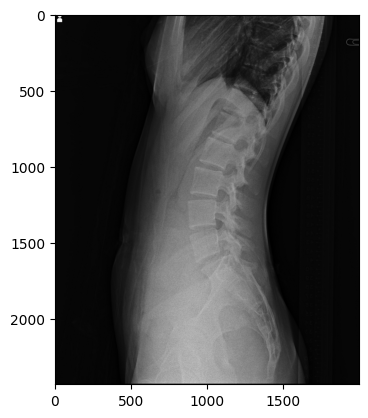

In [33]:
### Inference
model_path = '/content/drive/MyDrive/5. MY LOVE/기학지 플젝/Models_BB/Model_LA/Results/trained_la/weights/best.pt'
model = YOLO(model_path)

test_img_path = '/content/drive/MyDrive/5. MY LOVE/기학지 플젝/DATA/LA/0023-F-014Y1.jpg'
test_img = cv2.imread(test_img_path)

# Inference
results = model(test_img)

for result in results:
    boxes = result.boxes
    print(f"{len(boxes)}개의 박스가 만들어졌어용..")
    confs = boxes.conf.cpu().numpy()
    coords = boxes.xyxy.cpu().numpy()

    # 상위 5개만
    top_5_idx = np.argsort(confs)[-5:][::-1]

    for index in top_5_idx:
        x1, y1, x2, y2 = map(int, coords[index])
        color = (0, 255, 0)
        cv2.rectangle(test_img, (x1, y1), (x2, y2), color, 5)

plt.imshow(cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB))
plt.show()

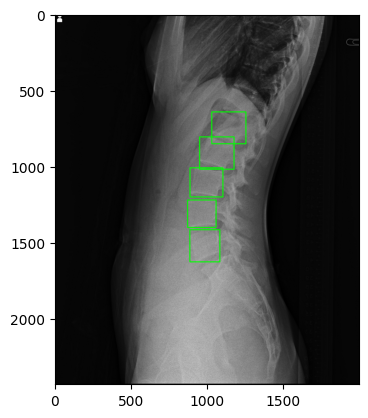

In [27]:
# 첫 사진, 설명 경로
first_image_path ='/content/drive/MyDrive/5. MY LOVE/기학지 플젝/DATA/LA/0023-F-014Y1.jpg'
first_bb_path = '/content/drive/MyDrive/5. MY LOVE/기학지 플젝/DATA/LA/0023-F-014Y1_bb.txt'

# 이미지 불러오기
image = cv2.imread(first_image_path)
height, width, _ = image.shape

# 바운딩박스 그리기
with open(first_bb_path, "r") as f:
    lines = f.readlines()
for line in lines:
    parts = line.strip().split()
    class_id, x_center, y_center, box_w, box_h = map(float, parts)

    # YOLO 형식 → 픽셀 좌표 복원
    x_center *= width
    y_center *= height
    box_w *= width
    box_h *= height

    x1 = int(x_center - box_w / 2)
    y1 = int(y_center - box_h / 2)
    x2 = int(x_center + box_w / 2)
    y2 = int(y_center + box_h / 2)

    # 박스 그리기
    color = (0, 255, 0)
    cv2.rectangle(image, (x1, y1), (x2, y2), color, 5)

plt.imshow(image)
plt.show()